In [1]:
import sys
sys.path.append('/home/campbell/yulee/DAMM/new/code/pro')

from funcs import *

In [2]:
cohort = 'basel'
ss = 10
nc = 20

BatchSize = 128
learnRate = 1e-3
nm = 'student'
so = None
rr = 0
rv = 100 
r = 0

In [3]:
analysisProteins = ['CD20', 'CD3', 'CD44', 'CD45', 'CD68', 'Carbonic_Anhydrase_IX',
       'Cytokeratin19', 'Cytokeratin5', 'Cytokeratin7', 'Cytokeratin8/18',
       'DNA1', 'DNA2', 'EGFR', 'Ecadherin', 'EpCAM', 'Erk1/2', 'Fibronectin',
       'GATA3', 'H3K27me3', 'Keratin14', 'Ki67', 'Progesterone_Receptor_A/B',
       'RabbitIgGHL', 'S6', 'SMA', 'Slug', 'Sox9', 'TotalHH3', 'Twist', 
       'Vimentin', 'bCatenin', 'cMyc', 'cerbB2_Her2', 'cleavedPARP_CleavedCaspase3',
       'mTOR', 'p53', 'panCytokeratin/Keratin_Epithelial', 'phospho_HH3', 'vWF_CD31']

pretty_printing = ['CD20', 'CD3', 'CD44', 'CD45', 'CD68', 'CAIX', 
                    'CK19', 'CK5', 'CK7', 'CK8/18', 
                    'DNA1', 'DNA2', 'EGFR', 'ECadherin', 'EpCAM', 'Erk', 'Fibronectin', 
                    'GATA3', 'H3K27me3', 'CK14', 'Ki67', 'PR', 
                    'Estroge', 'S6', 'SMA', 'Slug', 'Sox9', 'TotHH3', 'Twist',
                    'Vimentin', 'bCatenin', 'cMyc', 'Her2', 'cleavedPARP', 
                    'mTOR', 'p53', 'panCK', 'phosHH3', 'vWF'] 

tr_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_exp.h5ad'.format(cohort, ss))
te_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_exp.h5ad'.format(cohort, ss))

tr_so = torch.load('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_so.zip'.format(cohort, ss))
te_so = torch.load('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_so.zip'.format(cohort, ss))

trY, trS, Theta = prepData(tr_exp, nc, analysisProteins)
trFY, trFS, trFL = simulate_data(trY, trS)

teY, teS, _ = prepData(te_exp, nc, analysisProteins)
teFY, teFS, teFL = simulate_data(teY, teS)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
import joblib
## get random forest classifier
rf = RandomForestClassifier()
rf.fit(torch.hstack([trFY, trFS.reshape(-1,1)]), trFL)
rf_p_fake_singlet = rf.predict_proba(torch.hstack([teFY, teFS.reshape(-1,1)]))[:,1]
rf_tn, rf_fp, rf_fn, rf_tp, rf_acc, rf_f1, rf_sens, rf_spec = evalM(rf_p_fake_singlet, teFL)
#torch.hstack([teFY, teFS.reshape(-1,1)])
#joblib.dump(rf, "./random_forest.joblib")
#loaded_rf = joblib.load("./random_forest.joblib")

In [5]:
## kmeans mu & psi
mu0 = Theta['log_mu'].exp().detach()
psi0 = Theta['log_psi'].exp().detach()

In [6]:
## get labels
pred_singlet_label, pred_singlet_cluster_assig_label, _ = get_assign_labels(trY, trS, Theta, nm, so, tr_so, rr)

In [7]:
## sorted mu & psi
smu0 = mu0[pd.Series(pred_singlet_cluster_assig_label[0]).value_counts().index]
spsi0 = psi0[pd.Series(pred_singlet_cluster_assig_label[0]).value_counts().index]

# UMAP of Kmeans clusters

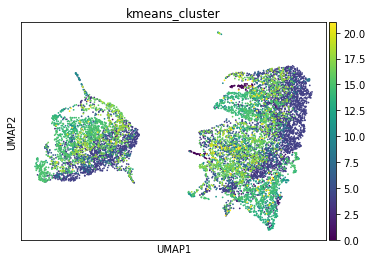

In [8]:
## kmeans cluster
tr_exp.obs['kmeans_cluster'] = smu0.shape[0] + 1
tr_exp.obs.iloc[np.where(pred_singlet_label[0] == 0)[0],-1] = np.array(pred_singlet_cluster_assig_label[0])

sc.pp.neighbors(tr_exp, use_rep='X')
sc.tl.umap(tr_exp)
sc.pl.umap(tr_exp, color="kmeans_cluster")

# Kmeans cluster expressions (sorted)

Text(34.0, 0.5, 'Cluster')

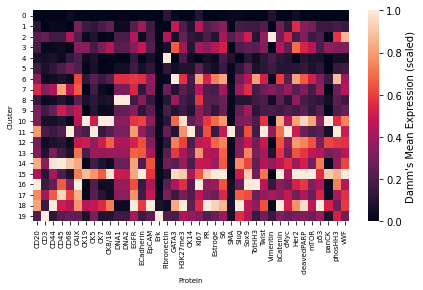

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
s2 = scaler.fit(smu0)
s3 = scaler.transform(smu0)
mat = pd.DataFrame(s3, columns = pretty_printing)

ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Damm's Mean Expression (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 7, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 7, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein", size = 7)
plt.ylabel("Cluster", size = 7)

In [10]:
## doublet probability for each cluster
rf.predict_proba(torch.hstack([smu0, spsi0.reshape(-1,1)]))[:,0] 

array([0.6 , 0.66, 0.25, 0.46, 0.43, 0.65, 0.38, 0.77, 0.73, 0.86, 0.32,
       0.38, 0.45, 0.58, 0.56, 0.31, 0.43, 0.47, 0.47, 0.72])

# Arcsinh (0.1) of cluster expressions

Text(34.0, 0.5, 'Cluster')

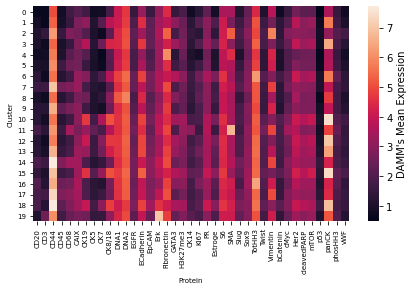

In [11]:
mat = pd.DataFrame(np.arcsinh(np.array(smu0)/0.1), columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expression"})
ax.set_xticklabels(ax.get_xticklabels(), size = 7, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 7, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein", size = 7)
plt.ylabel("Cluster", size = 7)

# Cell sizes in each cluster (Kmeans)

<AxesSubplot:xlabel='cluster', ylabel='size'>

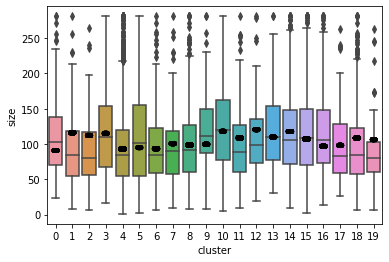

In [12]:
d1 = pd.DataFrame({'cluster': range(smu0.shape[0]), 'psi': spsi0})
d2 = pd.DataFrame({'size': trS[pred_singlet_label[0] == 0], 
                   'cluster': np.array(pred_singlet_cluster_assig_label[0].detach())})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

# Correlation

In [13]:
df_corr = pd.DataFrame(np.array(smu0), columns = pretty_printing).corr()
print("correlation between CD3 and CD20:                      {}".format(df_corr.loc['CD3','CD20']))
print("correlation between CD3 and CD68:                      {}".format(df_corr.loc['CD3','CD68']))
print("correlation between Vimentin and ECadherin:            {}".format(df_corr.loc['Vimentin','ECadherin']))
print("correlation between Vimentin and Fibronectin:          {}".format(df_corr.loc['Vimentin','Fibronectin']))
print("correlation between EpCAM and ECadherin:               {}".format(df_corr.loc['EpCAM','ECadherin']))
print("correlation between EpCAM and panCK:                   {}".format(df_corr.loc['EpCAM','panCK']))
print("correlation between ECadherin and CD68:                {}".format(df_corr.loc['ECadherin','CD68']))

correlation between CD3 and CD20:                      0.2271505616747681
correlation between CD3 and CD68:                      0.404778368975628
correlation between Vimentin and ECadherin:            -0.5320321465902146
correlation between Vimentin and Fibronectin:          0.4748026546514309
correlation between EpCAM and ECadherin:               0.4994411506073218
correlation between EpCAM and panCK:                   0.42213626171443197
correlation between ECadherin and CD68:                -0.32816685174096444


In [14]:
## run DAMM
loss, Theta = trainWFD(ConcatDataset(trY, trS, trFY, trFS, trFL), Theta, BatchSize, nm, learnRate, rv, so, tr_so, rr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


# Loss Function

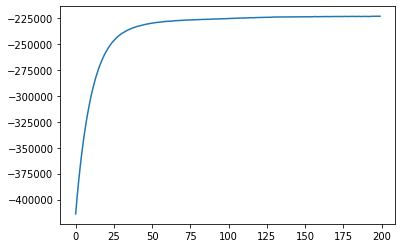

In [15]:
## total loss
plt.plot(np.array(loss)[:,0])

In [16]:
with torch.no_grad():
    ## watch out for when input matrix are big!!
    _, _, _ , damm_p_fake_singlet = compute_posteriors_nll_p_singlet(teFY, teFS, Theta, nm, so, te_so, rr)
    
    tn, fp, fn, tp, acc, f1, sens, spec = evalM(damm_p_fake_singlet, teFL)
    cor2 = np.corrcoef(damm_p_fake_singlet, rf_p_fake_singlet)

    iter_out = [nc, nm, rv, so, rr, r, len(np.where(damm_p_fake_singlet > 0.5)[0]), tn, fp, fn, tp, acc, f1, sens, spec, 
            len(np.where(rf_p_fake_singlet > 0.5)[0]), rf_tn, rf_fp, rf_fn, rf_tp, rf_acc, rf_f1, rf_sens, rf_spec, cor2[0,1]]

    output_pred_doublet = pd.Series(iter_out) #.to_csv(output_pred_doublet)

In [17]:
## damm mu & psi
mu1 = Theta['log_mu'].exp().detach()
psi1 = Theta['log_psi'].exp().detach()

In [18]:
## get labels
pred_singlet_label, pred_singlet_cluster_assig_label, _ = get_assign_labels(trY, trS, Theta, nm, so, tr_so, rr)

In [19]:
## sorted mu & psi
smu1 = mu1[pd.Series(pred_singlet_cluster_assig_label[0]).value_counts().index]
spsi1 = psi1[pd.Series(pred_singlet_cluster_assig_label[0]).value_counts().index]

# UMAP of DAMM clusters

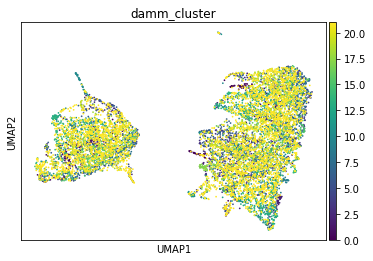

In [20]:
## damm cluster
tr_exp.obs['damm_cluster'] = smu1.shape[0] + 1
tr_exp.obs.iloc[np.where(pred_singlet_label[0] == 0)[0],-1] = np.array(pred_singlet_cluster_assig_label[0])

sc.pl.umap(tr_exp, color="damm_cluster")

# DAMM's cluster expressions

Text(34.0, 0.5, 'Cluster')

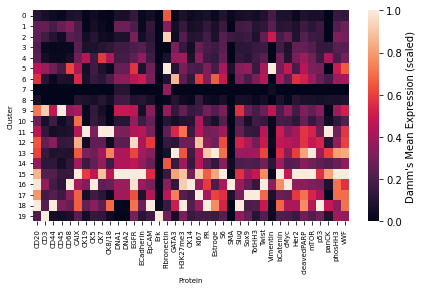

In [21]:
scaler = MinMaxScaler()
s2 = scaler.fit(smu1)
s3 = scaler.transform(smu1)
mat = pd.DataFrame(s3, columns = pretty_printing)

ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Damm's Mean Expression (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 7, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 7, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein", size = 7)
plt.ylabel("Cluster", size = 7)

In [22]:
## doublet probability for each cluster
rf.predict_proba(torch.hstack([smu1, spsi1.reshape(-1,1)]))[:,0]

array([0.23, 0.14, 0.18, 0.08, 0.15, 0.11, 0.12, 0.03, 0.08, 0.16, 0.28,
       0.11, 0.29, 0.23, 0.38, 0.04, 0.06, 0.1 , 0.32, 0.31])

# Arcsinh (0.1) version

Text(34.0, 0.5, 'Cluster')

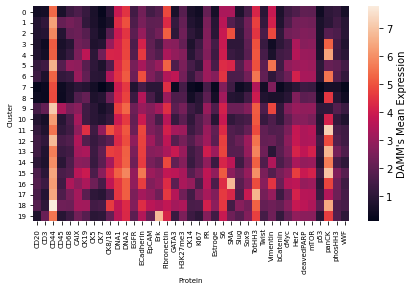

In [23]:
mat = pd.DataFrame(np.arcsinh(np.array(smu1)/0.1), columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expression"})
ax.set_xticklabels(ax.get_xticklabels(), size = 7, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 7, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein", size = 7)
plt.ylabel("Cluster", size = 7)

# Cell sizes in each cluster (DAMM)

<AxesSubplot:xlabel='cluster', ylabel='size'>

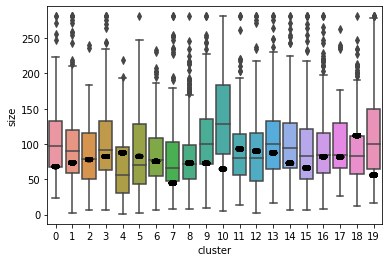

In [24]:
d1 = pd.DataFrame({'cluster': range(smu1.shape[0]), 'psi': spsi1})
d2 = pd.DataFrame({'size': trS[pred_singlet_label[0] == 0], 
                   'cluster': np.array(pred_singlet_cluster_assig_label[0].detach())})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

In [25]:
df_corr = pd.DataFrame(np.array(smu1), columns = pretty_printing).corr()
print("correlation between CD3 and CD20:                      {}".format(df_corr.loc['CD3','CD20']))
print("correlation between CD3 and CD68:                      {}".format(df_corr.loc['CD3','CD68']))
print("correlation between Vimentin and ECadherin:            {}".format(df_corr.loc['Vimentin','ECadherin']))
print("correlation between Vimentin and Fibronectin:          {}".format(df_corr.loc['Vimentin','Fibronectin']))
print("correlation between EpCAM and ECadherin:               {}".format(df_corr.loc['EpCAM','ECadherin']))
print("correlation between EpCAM and panCK:                   {}".format(df_corr.loc['EpCAM','panCK']))
print("correlation between ECadherin and CD68:                {}".format(df_corr.loc['ECadherin','CD68']))

correlation between CD3 and CD20:                      0.2532132911469255
correlation between CD3 and CD68:                      0.32962539496785126
correlation between Vimentin and ECadherin:            -0.3509578739134202
correlation between Vimentin and Fibronectin:          0.7914861478878366
correlation between EpCAM and ECadherin:               0.46235544291676967
correlation between EpCAM and panCK:                   0.4110611046653522
correlation between ECadherin and CD68:                -0.059517881931291726


# DAMM doublet probability

In [26]:
with torch.no_grad():
    _, _, _, p_singlet = compute_posteriors_nll_p_singlet(trY, trS, Theta, nm, so, tr_so, rr)

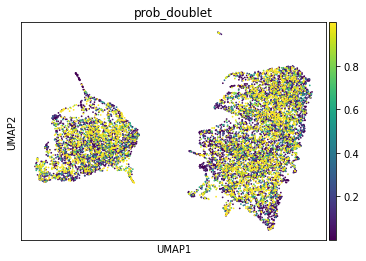

In [27]:
tr_exp.obs['prob_doublet'] = 1 - np.array(p_singlet.detach())
sc.pl.umap(tr_exp, color="prob_doublet")

# PhenoGraph cluster expressions

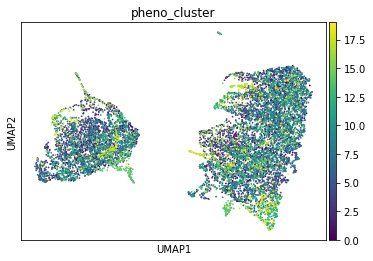

In [28]:
pheno = pd.read_csv('/home/campbell/yulee/DAMM/new/res/basel/10k/pheno/model/phenograph_assignments_30_0.csv')
tr_exp.obs['pheno_cluster'] = np.array(np.array(pheno)[:,1])
sc.pl.umap(tr_exp, color="pheno_cluster")

In [29]:
'''
Make a umap of the basel and eddy data, and colour by
Kmeans cluster
Damm cluster
Phenograph cluster
p(doublet)
'''

'\nMake a umap of the basel and eddy data, and colour by\nKmeans cluster\nDamm cluster\nPhenograph cluster\np(doublet)\n'